# Optimizer

## EMA

In [91]:
import numpy as np
import torch 
from torch import nn,optim
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch.utils.data import DataLoader
%load_ext autoreload
%autoreload 2
import utils
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


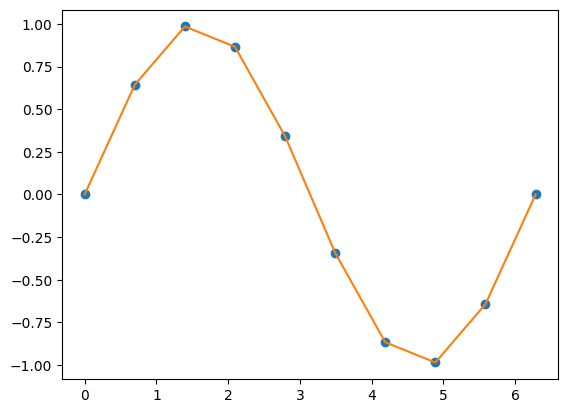

In [22]:
# sin(x)の関数をプロット
x = np.linspace(0, 2*np.pi, 10)
y = np.sin(x)
plt.plot(x, y, 'o')
plt.plot(x, y, '-')

In [15]:
def EMA(alpha, x):
    # np.zeros_like(x)はxと同じ形状の0で初期化された配列を作成
    y = np.zeros_like(x)  # 出力を格納する配列を作成
    y[0] = x[0]  # 初期値はxの最初の値とする
    for t in range(1, len(x)):
        y[t] = alpha * x[t] + (1 - alpha) * y[t-1]  # EMAの計算式
    return y

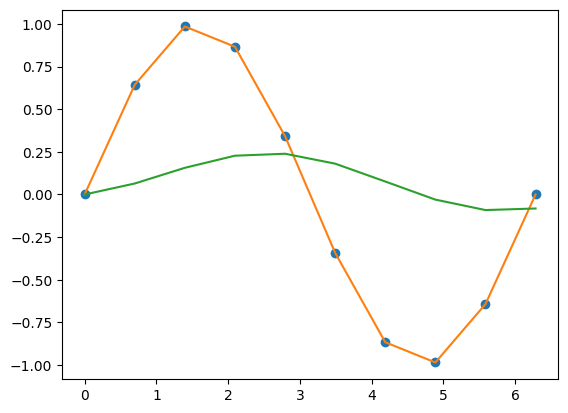

In [25]:
y_ema = EMA(0.1, y)
plt.plot(x, y, 'o')
plt.plot(x, y, '-')
plt.plot(x, y_ema, '-')

In [26]:
# 単純なEMAの作成
ema = 0
results = []
alpha = 0.8

for y_i in y:
    ema = alpha * ema + (1 - alpha) * y_i
    results.append(ema)

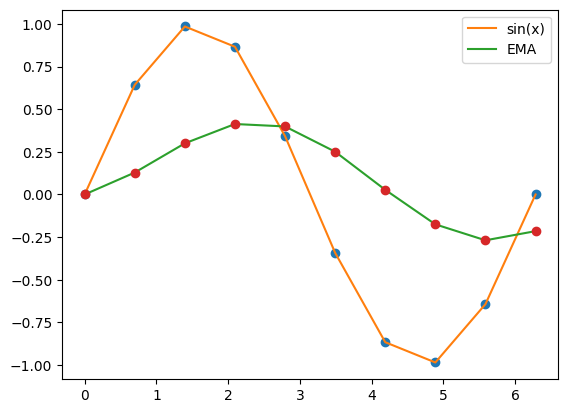

In [29]:
plt.plot(x, y, 'o')
plt.plot(x, y, label='sin(x)')
plt.plot(x, results, label='EMA')
plt.plot(x, results, 'o')
plt.legend()


### スクラッチでMomentum Optimizerをスクラッチで実装する

自作でoptimizerを作成する

In [49]:
class MomentumOptimizer():

    def __init__(self, parameters, lr=0.03, momentum=0.9):
        self.parameters = list(parameters)
        self.lr = lr
        self.momentum = momentum
        self.v = [torch.zeros_like(param) for param in self.parameters]

    def step(self):
        with torch.no_grad():
            for param, v in zip(self.parameters, self.v):
                v[:] = self.momentum * v + param.grad
                param -= self.lr * v

    # 勾配の初期化
    def zero_grad(self):
        for param in self.parameters:
            if param.grad is not None:
                param.grad.zero_()

In [50]:
class Optimizer():

    def __init__(self, parameters, lr=0.03):
        self.parameters = parameters
        self.lr = lr

    # 更新
    def step(self):
        with torch.no_grad():
            for param in self.parameters:
                param -= self.lr * param.grad

    # 勾配の初期化
    def zero_grad(self):
        for param in self.parameters:
            param.grad.zero_()

In [51]:
conv_model = utils.get_conv_model()

In [52]:
MomentumOptimizer(conv_model.parameters(), lr=0.03, momentum=0.9)

In [53]:
# データは今回はFMNISTを使う

# データ準備
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5,)),
])



train_dataset = torchvision.datasets.FashionMNIST('./fminist_data', train = True, download=True, transform=transform)
val_dataset = torchvision.datasets.FashionMNIST('./fminist_data', train = False, download=True, transform=transform)

# dataloader 
train_loader = DataLoader(train_dataset, batch_size = 1024, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size = 1024, num_workers=4)

opt = MomentumOptimizer(conv_model.parameters(), lr=0.03, momentum=0.9)

In [54]:
train_losses, val_losses, val_accuracy = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, 3)

epoch: 0: train error: 1.4275809172856606, validation error: 0.8704800248146057, validation accuracy: 0.7078105092048645


epoch: 1: train error: 0.6993667180255309, validation error: 0.6227316379547119, validation accuracy: 0.7783322691917419


epoch: 2: train error: 0.5499738318435217, validation error: 0.539646428823471, validation accuracy: 0.8066864609718323


In [ ]:
opt = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)

## RMSPropをスクラッチで実装する

In [83]:
class RMSpropOptimizer():

    def __init__(self, parameters, lr=0.03, beta=0.9, eps=1e-8):
        self.parameters = list(parameters)
        self.lr = lr
        self.beta = beta
        self.eps = eps
        self.s = [torch.zeros_like(param) for param in self.parameters]

    def step(self):
        with torch.no_grad():
            for param, s in zip(self.parameters, self.s):
                s[:] = self.beta * s + (1 - self.beta) * param.grad**2
                param -= self.lr * param.grad/ (torch.sqrt(s) + self.eps)

    # 勾配の初期化
    def zero_grad(self):
        for param in self.parameters:
            if param.grad is not None:
                param.grad.zero_()

In [84]:
# データは今回はFMNISTを使う

# データ準備
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5,)),
])



train_dataset = torchvision.datasets.FashionMNIST('./fminist_data', train = True, download=True, transform=transform)
val_dataset = torchvision.datasets.FashionMNIST('./fminist_data', train = False, download=True, transform=transform)

# dataloader 
train_loader = DataLoader(train_dataset, batch_size = 1024, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size = 1024, num_workers=4)

conv_model = utils.get_conv_model()
opt = RMSpropOptimizer(conv_model.parameters(), lr=0.03, beta = 0.9)

In [85]:
train_losses, val_losses, val_accuracy = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, 3)

epoch: 0: train error: 0.7736706203323299, validation error: 0.5971137166023255, validation accuracy: 0.7814114332199097


epoch: 1: train error: 0.4597283591658382, validation error: 0.44465852379798887, validation accuracy: 0.8425362706184387


epoch: 2: train error: 0.4017787409030785, validation error: 0.5165033459663391, validation accuracy: 0.8009845316410065


In [92]:
conv_model = utils.get_conv_model()
opt = optim.RMSprop(conv_model.parameters(), alpha = 0.9, lr = 0.03, eps = 1e-6)

In [93]:
train_losses, val_losses, val_accuracy = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, 3)

epoch: 0: train error: 0.7465381213163925, validation error: 0.6142795264720917, validation accuracy: 0.7837472081184387


epoch: 1: train error: 0.4510397936327983, validation error: 0.5138012766838074, validation accuracy: 0.812310665845871


epoch: 2: train error: 0.3934349751068374, validation error: 0.5122609317302704, validation accuracy: 0.8017338991165162
